# Task 2a: Object Detection with Faster R-CNN

**Student:** Stefania Livori  
**Model:** Faster R-CNN (ResNet50 FPN)

This notebook implements a Faster R-CNN object detector to detect Maltese traffic signs. It covers:
1.  **Dataset Preparation**: Loading images and annotations.
2.  **Model Training**: Fine-tuning a pre-trained Faster R-CNN model.
3.  **Evaluation**: Calculating Mean Average Precision (mAP).
4.  **Inference & Analytics**: visualizing detections and counting signs per image.

In [22]:
# Import necessary libraries
import torch
from torch.utils.data import Dataset, DataLoader, random_split
import torchvision.transforms as T
from PIL import Image
import json, os
import matplotlib.pyplot as plt
from stefania_livori_utils import *

# Ensure reproducible results
torch.manual_seed(42)

## 1. Dataset Preparation

I define the `SignsDataset` class to load images and COCO-style annotations. 
**Note:** Images are stored in `data/` and annotations in `json_stefania.json`.

In [23]:
# Classes mapping
# Background is 0, so classes start from 1
CLASS_NAMES = {
    1: "Stop",
    2: "No Entry (One Way)",
    3: "Pedestrian Crossing",
    4: "Roundabout Ahead",
    5: "No Through Road (T-Sign)",
    6: "Blind-Spot Mirror (Convex)"
}

# + background
NUM_CLASSES = len(CLASS_NAMES) + 1

# https://medium.com/@RobuRishabh/understanding-and-implementing-faster-r-cnn-248f7b25ff96
class SignsDataset(Dataset):
    def __init__(self, root, annFile, transforms=None, preload=True):
        self.root = root
        self.transforms = transforms

        # Load the JSON file
        with open(annFile) as f:
            data = json.load(f)

        # Extract images and annotations
        self.images_info = data["images"]
        self.annotations = data["annotations"]

        # Map image_id to annotations for faster access
        self.imgToAnns = {img["id"]: [] for img in self.images_info}
        for ann in self.annotations:
            self.imgToAnns[ann["image_id"]].append(ann)

        self.preload = preload
        if preload:
            # Preload the images into memory for speed
            # This might cause memory usage
            self.loaded_images = []
            for img_info in self.images_info:
                # Handle potential path differences if filename contains folders
                # Assuming images are directly in root or filename matches relative structure
                img_name = os.path.basename(img_info["file_name"])
                img_path = os.path.join(root, img_name)
                
                try:
                    with Image.open(img_path) as img:
                        self.loaded_images.append(img.convert("RGB").copy())
                except FileNotFoundError:
                    # Error if an image is not found
                    raise FileNotFoundError(f"Image not found at {img_path}")

    def __getitem__(self, idx):
        img_info = self.images_info[idx]
        image_id = img_info["id"]

        if self.preload:
            # load the image 
            img = self.loaded_images[idx].copy()
        else:
            img_name = os.path.basename(img_info["file_name"])
            img_path = os.path.join(self.root, img_name)
            img = Image.open(img_path).convert("RGB")

        anns = self.imgToAnns[image_id]
        boxes = []
        labels = []

        for ann in anns:
            x, y, w, h = ann["bbox"]
            boxes.append([x, y, x + w, y + h])
            labels.append(ann["category_id"] + 1)

        # Guard against images with no annotations if necessary
        if not boxes:
             # Handle empty target
             boxes = torch.zeros((0, 4), dtype=torch.float32)
             labels = torch.zeros((0,), dtype=torch.int64)
        else:
             boxes = torch.tensor(boxes, dtype=torch.float32)
             labels = torch.tensor(labels, dtype=torch.int64)

        target = {
            "boxes": boxes,
            "labels": labels,
            "image_id": torch.tensor([image_id])
        }

        if self.transforms:
            img = self.transforms(img)

        return img, target

    def __len__(self):
        return len(self.images_info)

### Initialize Dataset and DataLoaders

In [24]:
transform = T.Compose([T.ToTensor()])

# Update paths here to match your environment
DATA_DIR = "label-studio/label-studio/media/upload/2" 
ANNOTATION_FILE = "stefania_livori/result.json"

dataset = SignsDataset(
    root=DATA_DIR,
    annFile=ANNOTATION_FILE,
    transforms=transform
)

# Split dataset 
val_size = int(0.2 * len(dataset))
train_size = len(dataset) - val_size
train_dataset, val_dataset = random_split(dataset, [train_size, val_size])

print(f"Training set size: {len(train_dataset)}")
print(f"Validation set size: {len(val_dataset)}")

# https://github.com/GirinChutia/FasterRCNN-Torchvision-FineTuning/blob/main/train.py
train_loader = DataLoader(
    train_dataset,
    batch_size=4,
    shuffle=True,
    collate_fn=lambda x: tuple(zip(*x))
)

val_loader = DataLoader(
    val_dataset,
    batch_size=2,
    shuffle=False,
    collate_fn=lambda x: tuple(zip(*x))
)

Training set size: 120
Validation set size: 30


## 2. Model Configuration
Loading the Faster R-CNN model pre-trained on COCO and adapting proper number of classes.

In [25]:
device = get_device()
model = get_faster_rcnn(NUM_CLASSES).to(device)

# Optimizer & Scheduler
# https://github.com/GirinChutia/FasterRCNN-Torchvision-FineTuning/blob/main/train.py
# optimizer logic based on the github link above
optimizer = torch.optim.SGD(
    model.parameters(),
    lr=0.005,
    momentum=0.9,
    weight_decay=0.0005
)


# Might need to try different step sizes
scheduler = torch.optim.lr_scheduler.StepLR(
    optimizer, step_size=3, gamma=0.1
)

Using device: cuda


## 3. Training Loop
Training for 3 epochs and evaluating on validation set after each epoch.

In [26]:
num_epochs = 3

# Training Loop
# https://medium.com/@RobuRishabh/understanding-and-implementing-faster-r-cnn-248f7b25ff96 
for epoch in range(num_epochs):
    print(f"\nStarting Epoch {epoch+1}/{num_epochs}")
    avg_loss = train_one_epoch(model, train_loader, optimizer, device)
    scheduler.step()
    
    # Evaluate
    map50 = evaluate_map50(model, val_loader, device)

    print(f"Epoch [{epoch+1}/{num_epochs}] Loss: {avg_loss:.4f} | mAP@0.5: {map50:.4f}")

print("Training finished!")


Starting Epoch 1/3
Epoch [1/3] Loss: 0.3976 | mAP@0.5: 0.0000

Starting Epoch 2/3
Epoch [2/3] Loss: 0.2656 | mAP@0.5: 0.0000

Starting Epoch 3/3
Epoch [3/3] Loss: 0.2455 | mAP@0.5: 0.0000
Training finished!


## 4. Analytics & Visualization

Analyze the detections on the validation set. I will count the number of detected signs and visualize the results.

In [27]:
# Inference + Visualization - Inference applying the trained model to unlabeled examples so that it can
# make the respective predictions
model.eval()

# Analytic - Count detections per image in validation set
# print("GT labels:", target["labels"])
# print("Pred labels:", pred["labels"][:5])
# print("Scores:", pred["scores"][:5])
total_detected_signs = 0
results_summary = []

with torch.no_grad():
    for i, (img, target) in enumerate(val_dataset):
        # Inference
        prediction = model([img.to(device)])[0]
        
        # Filter by score threshold (e.g. 0.5)
        keep = prediction["scores"] > 0.5
        final_boxes = prediction["boxes"][keep]
        final_labels = prediction["labels"][keep]
        final_scores = prediction["scores"][keep]
        
        count = len(final_labels)
        total_detected_signs += count
        
        results_summary.append({
            "ImageID": target["image_id"].item(),
            "DetectedSigns": count,
            "Labels": [CLASS_NAMES.get(l.item(), "Unknown") for l in final_labels]
        })

print(f"Total signs detected in validation set: {total_detected_signs}")
print("Sample results (first 5):")
for res in results_summary[:5]:
    print(res)

Total signs detected in validation set: 0
Sample results (first 5):
{'ImageID': 72, 'DetectedSigns': 0, 'Labels': []}
{'ImageID': 139, 'DetectedSigns': 0, 'Labels': []}
{'ImageID': 131, 'DetectedSigns': 0, 'Labels': []}
{'ImageID': 60, 'DetectedSigns': 0, 'Labels': []}
{'ImageID': 65, 'DetectedSigns': 0, 'Labels': []}



Visualizing Sample Predictions:
Image 1 Ground Truth: ['Blind-Spot Mirror (Convex)', 'No Entry (One Way)'] 


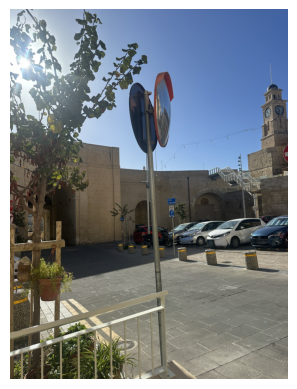

Image 2 Ground Truth: ['No Through Road (T-Sign)'] 


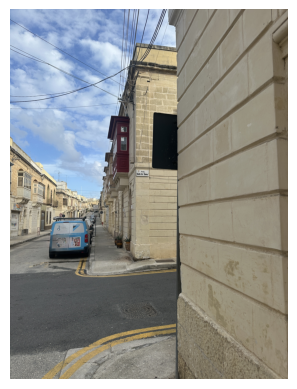

Image 3 Ground Truth: ['Blind-Spot Mirror (Convex)'] 


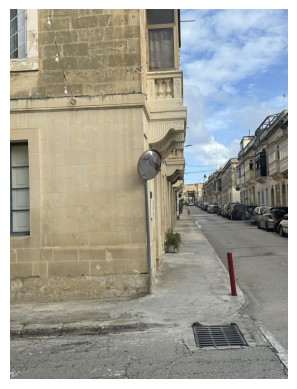

In [28]:
# Visualizing predictions on a few samples
print("\nVisualizing Sample Predictions:")
for i in range(3):
    img, target = val_dataset[i]
    with torch.no_grad():
        prediction = model([img.to(device)])[0]

    print(f"Image {i+1} Ground Truth: {[CLASS_NAMES[l.item()] for l in target['labels']]} ")
    visualize_predictions(img, prediction, CLASS_NAMES, threshold=0.5)